In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

from composition_stats import ilr, ilr_inv, closure
from statsmodels.tsa.seasonal import seasonal_decompose

In [18]:
raw_data = pd.read_excel("Datos_Market_copy.xlsx")

data = raw_data.copy()
data.set_index("date", inplace=True)

In [22]:
"We're gonna group some data for simplicity"
for i in data["brand"]:
    if i != "brand-15" and i != "brand-14" and i != "brand-35":
        # change the name
        # test_data["brand"].replace(i, "other", inplace=True)
        data["brand"].replace({i: "other"}, inplace=True)


print(
    "#########################################",
    "\nWe will use only four brands in our data",
    data["brand"].unique(),
)

######################################### 
We will use only four brands in our data ['brand-35' 'brand-14' 'other' 'brand-15']


In [52]:
# variant = data_withILR["variant"] == "standard"

# pack_size = data["pack.size"] == "0 - 350 GR"

pack_size = data["pack.size"].isin(["0 - 350 GR", "351 - 500 GR"])

brand35 = data["brand"].isin(["brand-35"])  # , "brand-15", "brand-14"
brand15 = data["brand"].isin(["brand-15"])
brand14 = data["brand"].isin(["brand-14"])

variantF = data["variant"].isin(["flavoured"])
variantL = data["variant"].isin(["light"])
variantS = data["variant"].isin(["standard"])
variantV = data["variant"].isin(["vegan"])

supermarketA = data["supermarket"].isin(["supermarket-A"])
supermarketB = data["supermarket"].isin(["supermarket-B"])
supermarketC = data["supermarket"].isin(["supermarket-C"])
supermarketD = data["supermarket"].isin(["supermarket-D"])

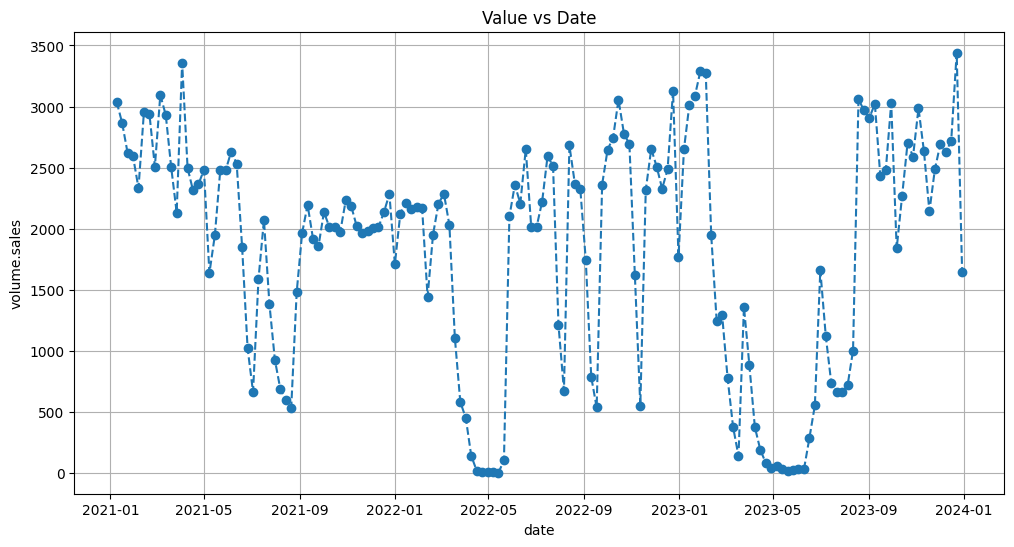

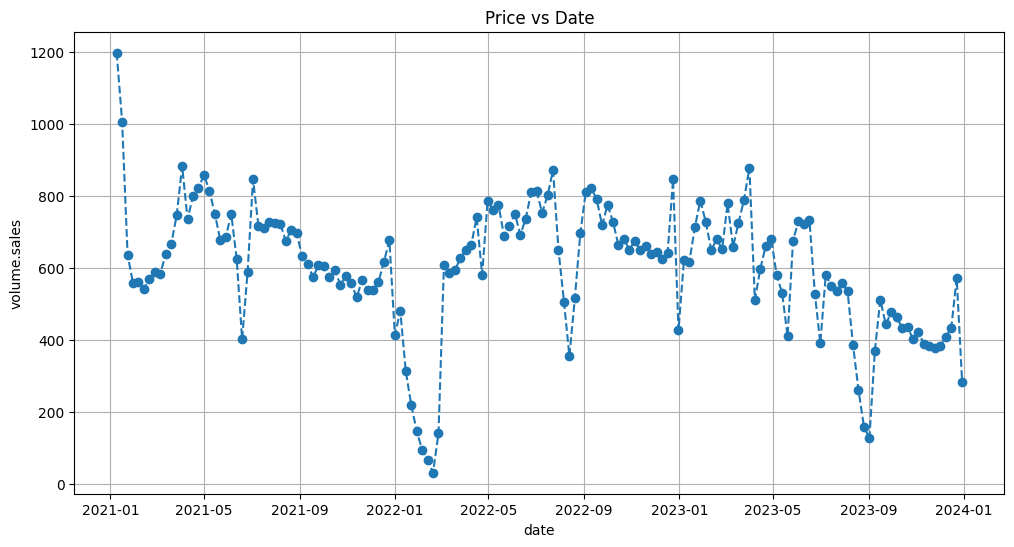

AttributeError: 'Axes' object has no attribute 'plot_series'

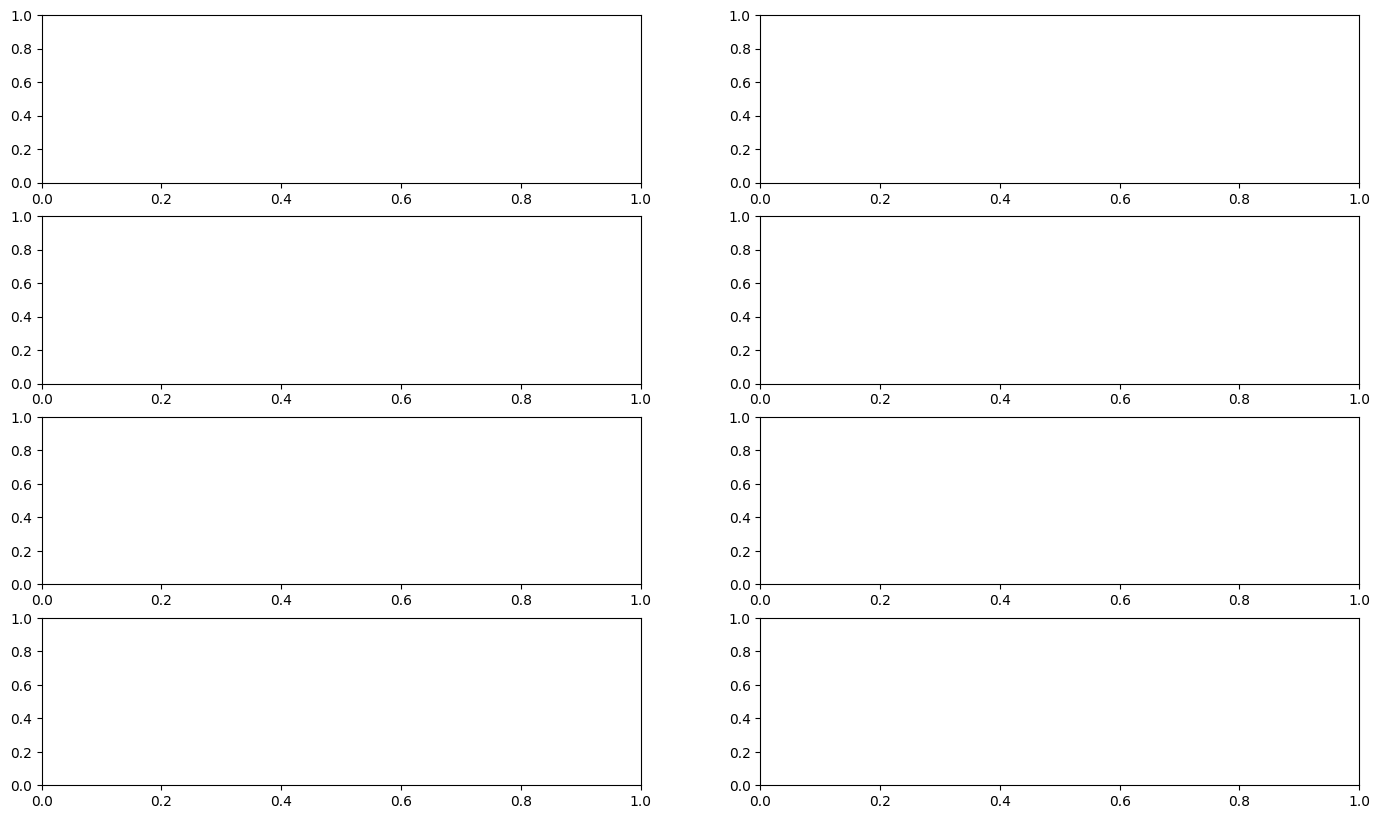

In [56]:
def plot_series(data, variable, title=None):
    plt.figure(figsize=(12, 6))
    plt.plot(data[variable], marker="o", linestyle="--")
    plt.xlabel("date")
    plt.ylabel(variable)
    plt.title(title)
    plt.grid(True)
    plt.show()


# plot of the first 100 data points
plot_series(
    data[(brand35) & (variantF) & (supermarketA) & (pack_size)],
    "volume.sales",
    title="Value vs Date",
)
plot_series(
    data[(brand35) & (variantV) & (supermarketA) & (pack_size)],
    "volume.sales",
    title="Price vs Date",
)


fig, ax = plt.subplots(4, 2, figsize=(17, 10))

ax[0, 0].plot_series(
    data[(brand35) & (variantF) & (supermarketA) & (pack_size)],
    "volume.sales",
    title="Value vs Date",
)
ax[0, 0].set_title("Serie Original - ILR_1")
ax[0, 0].grid(True)

# ax[1, 0].plot_series( data[(brand35) & (variantF) & (supermarketA) & (pack_size)],
#     "volume.sales",
#     title="Value vs Date",
# )

# ax[0, 1].plot_series( data[(brand35) & (variantF) & (supermarketA) & (pack_size)],
#     "volume.sales",
#     title="Value vs Date",
# )

# ax[0, 1].plot_series( data[(brand35) & (variantF) & (supermarketA) & (pack_size)],
#     "volume.sales",
#     title="Value vs Date",
# )